In [1]:
# Установка необходимых библиотек
!pip install gymnasium
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.0 MB/s eta 0:00:00


In [2]:
import torch as th
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [3]:
!pip install gymnasium[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects


In [4]:
!pip install swig # требуется для сборки box2d
!pip install gymnasium[box2d]

  Using cached swig-4.1.1.post1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=226f5737bd3414096d38d83de0dd678458dd3e9ae4fa900f00833bc46ebabba9
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


Q-значения (Q-values) представляют собой оценки или оценочные функции, используемые в контексте обучения с подкреплением для измерения ожидаемой полезности (ценности) принятия определенного действия в конкретном состоянии.

Для получения значений для нашей модели реализуем функцию, которая их извлекает из q-сети.

In [5]:
def q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
  # Доступ к Q-network
  q_net = model.q_net

  # Конвертируем observation в PyTorch tensor
  obs_tensor = th.tensor(obs, dtype=th.float32)

  # Изменяем размерность
  obs_tensor = obs_tensor.unsqueeze(0)

  #Извлекаем Q-values
  q_values = model.q_net.forward(obs_tensor)

  return q_values.detach().numpy()[0]

In [6]:
def plot_q_values(q_values_list):
  # Извлечение отдельных списков для каждого Q-значения
  q1_values, q2_values, q3_values, q4_values = zip(*q_values_list)

  # Построение графика
  plt.figure(figsize=(10, 6))
  plt.plot(q1_values, label='Q1 Values')
  plt.plot(q2_values, label='Q2 Values')
  plt.plot(q3_values, label='Q3 Values')
  plt.plot(q4_values, label='Q4 Values')
  plt.xlabel('Time')
  plt.ylabel('Q-Values')
  plt.title('Convergence of Q-Values over Time')
  plt.legend()
  plt.show()

In [15]:
def mean_reward(discount_factor):
  #Создание окружения
  env = gym.make("LunarLander-v2",
    continuous = False,
    enable_wind = False)

  #Создание модели
  model = DQN("MlpPolicy", env, verbose=1, gamma=discount_factor)

  #Количество эпизодов для оценки модели
  n_eval_episodes = 250

  #Оценка модели до обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("LunarLander-v2",
    continuous = False,
    enable_wind = False), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"До обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

  # Засекаем начальное время
  start_time = time.time()

  #Обучение модели
  model.learn(total_timesteps=100000, log_interval=10000)

  # Засекаем время завершения
  end_time = time.time()

  #Оценка модели после обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("LunarLander-v2",
    continuous = False,
    enable_wind = False), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"После обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
  model.save(f"dqn_cartpole_{discount_factor}")
  del model

  # Вычисляем время обучений
  learn_time = end_time - start_time
  return env, learn_time

In [16]:
def q_values_calculation(discount_factor, env):
  #Загружаем созданную и созраненную модель
  model = DQN.load(f"dqn_cartpole_{discount_factor}")

  #В CartPole окружении возможны только 2 действия
  action_str = ['left','right']
  q_values_list = []

  obs, info = env.reset()
  for _ in range(100):
      q_val = q_values(model,obs)
      q_values_list.append(q_val)
      action, _states = model.predict(obs, deterministic=True)

      # print(f"Q-value состояния left={q_val[0]:.2f} right={q_val[1]:.2f}")
      # print(f"Действие: {action_str[action]}")

      obs, reward, terminated, truncated, info = env.step(action)

  return q_values_list

In [17]:
discount_factors = [0.01,0.5,0.99]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.01, mean_reward:-125.18 +/- 44.96
После обучения модели с discount_factor = 0.01, mean_reward:-250.10 +/- 153.45


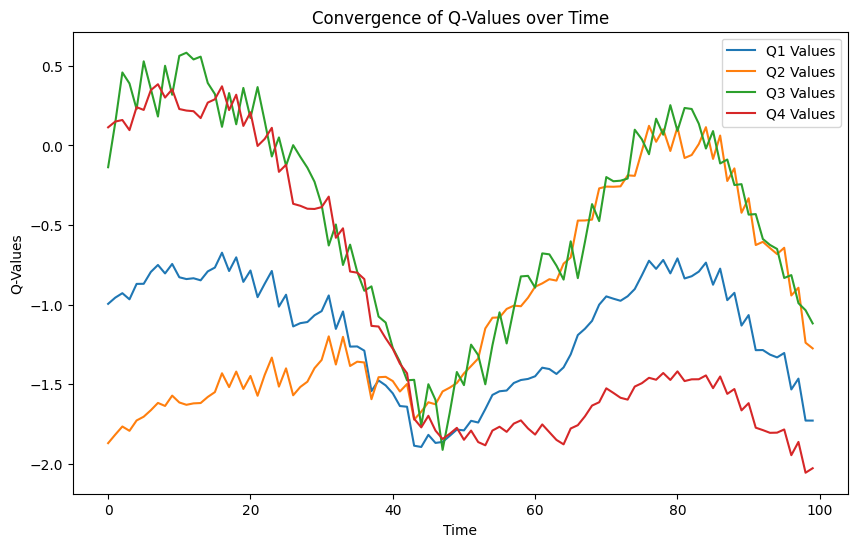

Время обучения модели при discount_factor = 0.01 : 65.47241115570068 секунд.


In [18]:
environment, time_to_lrn = mean_reward(discount_factors[0])
q_vals = q_values_calculation(discount_factors[0], environment)
plot_q_values(q_vals)
print(f'Время обучения модели при discount_factor = {discount_factors[0]} : {time_to_lrn} секунд.')

In [19]:
# Закрытие среды
environment.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.5, mean_reward:-130.07 +/- 41.60
После обучения модели с discount_factor = 0.5, mean_reward:-228.29 +/- 129.17


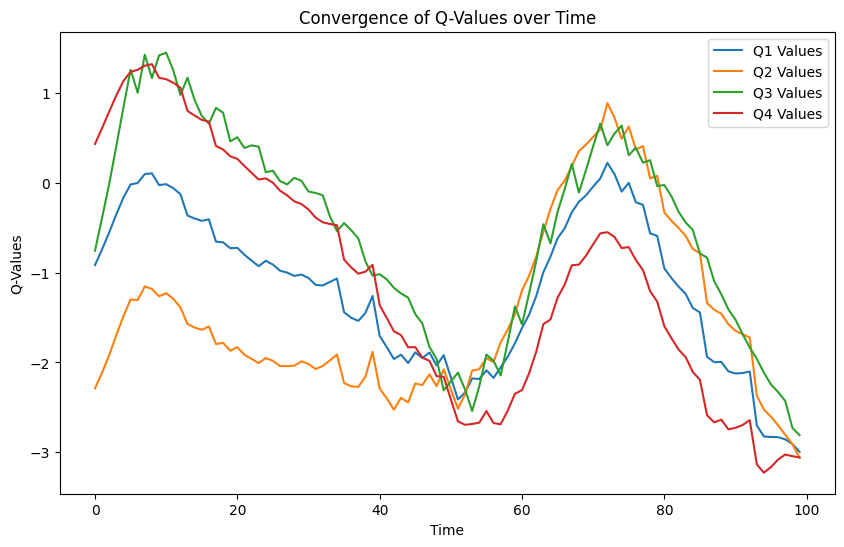

Время обучения модели при discount_factor = 0.5 : 65.40272879600525 секунд.


In [20]:
environment, time_to_lrn = mean_reward(discount_factors[1])
q_vals = q_values_calculation(discount_factors[1], environment)
plot_q_values(q_vals)
print(f'Время обучения модели при discount_factor = {discount_factors[1]} : {time_to_lrn} секунд.')

In [21]:
# Закрытие среды
environment.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.99, mean_reward:-578.18 +/- 158.77
После обучения модели с discount_factor = 0.99, mean_reward:-197.85 +/- 183.27


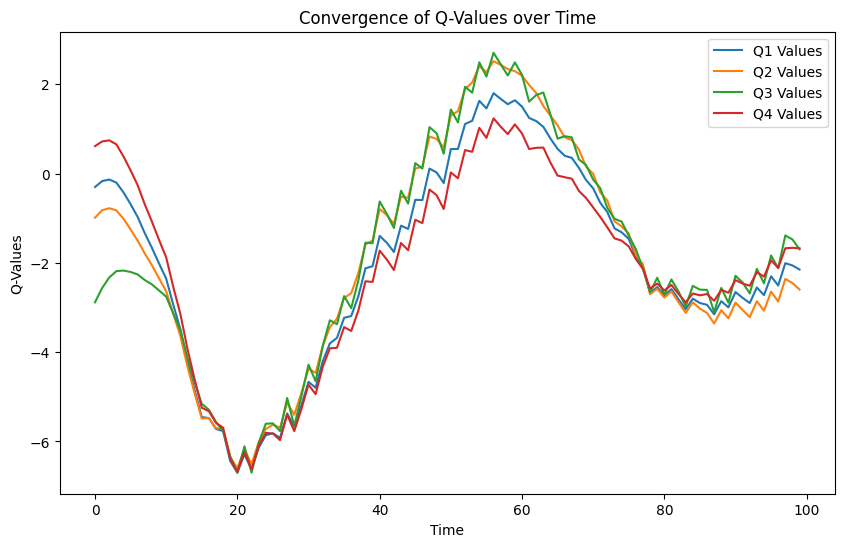

Время обучения модели при discount_factor = 0.99 : 65.7409131526947 секунд.


In [22]:
environment, time_to_lrn = mean_reward(discount_factors[2])
q_vals = q_values_calculation(discount_factors[2], environment)
plot_q_values(q_vals)
print(f'Время обучения модели при discount_factor = {discount_factors[2]} : {time_to_lrn} секунд.')

In [23]:
# Закрытие среды
environment.close()